# Data path

In [2]:
path = "/home/ubuntu/data/fisheries/"

# Imports

In [3]:
%matplotlib inline
#from theano.sandbox import cuda
#from __future__ import division, print_function

In [4]:
import sys
sys.path.append('PreTrainedModels')
import vgg16bn; reload(vgg16bn)
from vgg16bn import Vgg16BN

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [5]:
import sys
sys.path.append('utilities')
import utils; reload(utils)
from utils import *

# Create Adapted VGG model with batch normalization

In [7]:
vggbn_model = Vgg16BN(include_top=True)
vggbn_model.ft(8)
vggbn_model.compile()

Finetuned for 8 classes.


# Split conv and fc layers

In [8]:
conv_layers, fc_layers = split_at_last(vggbn_model.model, Convolution2D)

In [9]:
#Create conv model from conv layers
conv_model = Sequential(conv_layers)

In [61]:
#Create FC model: 
def get_fc_layers(p, in_shape):
    return [
        MaxPooling2D(input_shape=in_shape),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(8, activation='softmax')
        ]
# TODO - Figure out how to use returned FC layers-> 
# Exception: You are attempting to share a same `BatchNormalization` layer across different data flows. This is not possible. You should use `mode=2` in `BatchNormalization`, which has a similar behavior but is shareable (see docs for a description of the behavior).
# Tried attaching an input layer
# inp = Input(shape=conv_layers[-1].output_shape[1:])
# fc_layers = [inp] + fc_layers
# fc_model = Sequential(fc_layers) -> AttributeError: 'TensorVariable' object has no attribute 'inbound_nodes'
# Tried updating input shape of first layer
# fc_first_layer = fc_layers[0]
# fc_layers=fc_layers[1:]
# fc_first_layer = conv_layers[-1].output_shape[1:] -> same BN exception

In [62]:
layers = get_fc_layers(0.5, conv_layers[-1].output_shape[1:])
fc_model = Sequential(layers)

# Get data, labels and Generate conv features

In [12]:
#Get data as numpy arrays
trn, trn_labels = get_data(path=path+'train')

#TODO: Figure out how can we use batches instead? Advantage: data augmentation?
# Can get features in batches using predict_batches
# trn_features = conv_model.predict_generator(batches, batch_size)
# Can get trn label batches using gen.flow
# trn_label_batches = gen.flow(trn_labels, batch_size=batch_size, shuffle=False)
# How to use fit with feature and label batches?
# fc_model.fit_generator(trn_features, trn_label_batches, nb_epoch = 3, validation_data=(val_features, val_label_batches))

Found 3277 images belonging to 8 classes.


In [13]:
val, val_labels = get_data(path=path+'valid')
test, test_labels = get_data(path=path+'test') #ignore test_labels

Found 500 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


In [14]:
trn_feat = conv_model.predict(trn)

In [15]:
val_feat = conv_model.predict(val)
test_feat = conv_model.predict(test)

# Set up infra for observability

In [16]:
# Create a list to hold histories
historyList = list()

In [56]:
#Create a ModelCheckpoint to check point at best val_loss
from keras.callbacks import ModelCheckpoint
def getCheckPoint(name):
    filepath="results/" + name + "{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)
    return [checkpoint]

In [ ]:
# TODO: Set up Learning rate scheduler? Decay can be set in Adam optimizer but does not seem to be necessary?

# Fit conv features on FC model

In [63]:
fc_model.compile(optimizer=Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [48]:
#fc_model.load_weights('results/MP-F-[D-BN-DO(0.5)]2-D-00-0.99-0.08.hdf5')

In [44]:
#fc_model.evaluate(trn_feat, trn_labels)

3277/3277 [==============================] - 1s     


[0.036002044368637798, 0.996032956972841]

In [23]:
#Run around 3 epochs before calling ModelCheckPoint call back
historyList.append(fc_model.fit(trn_feat, trn_labels, nb_epoch = 1, validation_data=(val_feat, val_labels)))

Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 10s - loss: 0.1145 - acc: 0.9802 - val_loss: 0.3841 - val_acc: 0.9640


In [65]:
name = 'Exp1'
historyList.append(fc_model.fit(trn_feat, trn_labels, nb_epoch = 40, validation_data=(val_feat, val_labels), callbacks=getCheckPoint(name)))

Train on 3277 samples, validate on 500 samples
Epoch 1/40
3277/3277 [==============================] - 12s - loss: 0.1074 - acc: 0.9832 - val_loss: 0.5174 - val_acc: 0.9500
Epoch 2/40
3277/3277 [==============================] - 10s - loss: 0.0944 - acc: 0.9847 - val_loss: 0.5521 - val_acc: 0.9460
Epoch 3/40
3277/3277 [==============================] - 10s - loss: 0.0981 - acc: 0.9826 - val_loss: 0.5635 - val_acc: 0.9500
Epoch 4/40
3277/3277 [==============================] - 10s - loss: 0.1232 - acc: 0.9799 - val_loss: 0.6646 - val_acc: 0.9300
Epoch 5/40
3277/3277 [==============================] - 10s - loss: 0.1430 - acc: 0.9814 - val_loss: 0.6635 - val_acc: 0.9480
Epoch 6/40
3277/3277 [==============================] - 10s - loss: 0.1296 - acc: 0.9850 - val_loss: 0.5592 - val_acc: 0.9500
Epoch 7/40
3277/3277 [==============================] - 12s - loss: 0.1236 - acc: 0.9844 - val_loss: 0.5158 - val_acc: 0.9580
Epoch 8/40
3277/3277 [==============================] - 10s - loss: 0.1

# Plot loss and accuracy histories across epochs

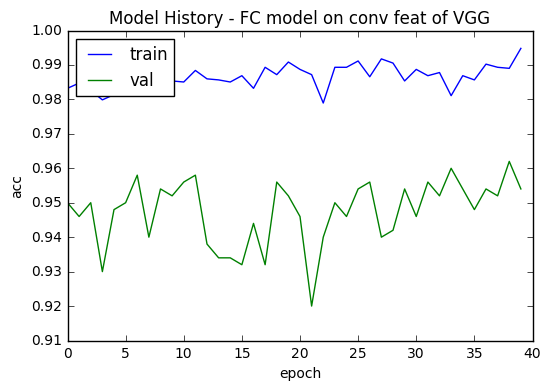

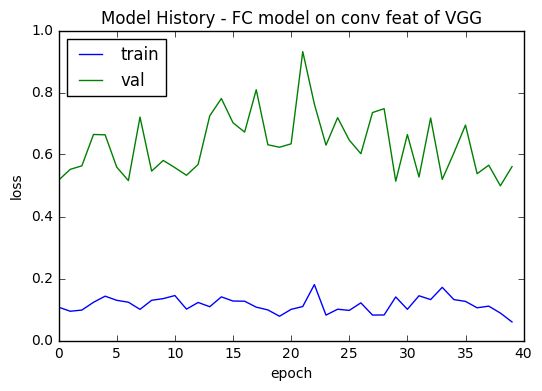

In [93]:
plot_history(historyList,metric='acc', model_description='FC model on conv feat of VGG')
plot_history(historyList, metric='loss', model_description='FC model on conv feat of VGG')